In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_and_parse(input_file):
    data = pd.read_csv(input_file)
    
#     Exclude the last events, as they are not interesting at all
    data = data[data["dataPullType"] != "none"]
    
#     Calculate the data and control time
    data['controlTime'] = (data['TotalDuration'] - data['DataPullDuration'] - data['DataPushDuration'] - data['ComputeDuration'])
    data['dataTime'] = data['DataPullDuration'] + data['DataPushDuration']
    
    data.loc[data['controlTime'] < 0, 'controlTime'] = 1
    
#     Calculate the trigger step network duration (for Connection Pooling experiment)
    data['triggerStepNetworkDuration'] = data['TriggerStepClientDuration'] - data['TriggerStepServerDuration']

#     
    row_total = data[['dataTime', 'controlTime', 'ComputeDuration']].sum(axis=1)

    data['dataPercentage'] = (data['dataTime'] / row_total) * 100
    data['controlPercentage'] = (data['controlTime'] / row_total) * 100
    data['computePercentage'] = (data['ComputeDuration'] / row_total) * 100
    
    
    return data

In [2]:
def avg_and_pct(pct, val_averages):
    absolute = int(round(pct/100.*np.sum(val_averages)))
    return "{:.1f}%\n({:d} ms)".format(pct, absolute)

def piechart(data, ds, ax):
    val_averages = data[['dataTime', 'controlTime', 'ComputeDuration']].mean()
    
    labels = ['data', 'control', 'compute']
    ax.pie(val_averages,  labels=labels, autopct=lambda pct: avg_and_pct(pct, val_averages),
        shadow=True)
    ax.set_title("Data size = {:d} bytes".format(ds))


def draw_data_loc_plots(local_averages_on, remote_averages_on, local_count_on, remote_count_on,
                       local_averages_off, remote_averages_off, local_count_off, remote_count_off):
    fig, axs = plt.subplots(2,2, figsize=(10,10))

    axs[0,0].plot(data_counts, local_averages_on, marker='o', label='Local averages (with data locality)')
    axs[0,0].plot(data_counts, local_averages_off, marker='o', label='Local averages (without data locality)')
    axs[0,0].set_ylabel('ms')
    axs[0,0].set_xlabel('# of parallel calls')
    axs[0,0].legend()


    axs[0,1].plot(data_counts, remote_averages_on, marker='o', label='Remote Averages (with data locality)')
    axs[0,1].plot(data_counts, remote_averages_off, marker='o', label='Remote Averages (without data locality)')
    axs[0,1].set_ylabel('ms')
    axs[0,1].set_xlabel('# of parallel calls')
    axs[0,1].legend()


    axs[1,0].plot(data_counts, local_count_on, marker='o', label='# of local calls (with data locality)')
    axs[1,0].plot(data_counts, local_count_off, marker='o', label='# of local calls (without data locality)')
    axs[1,0].set_ylabel('count')
    axs[1,0].set_xlabel('# of parallel calls')
    axs[1,0].legend()


    axs[1,1].plot(data_counts, remote_count_on, marker='o', label='# of remote calls (with data locality)')
    axs[1,1].plot(data_counts, remote_count_off, marker='o', label='# of remote calls (without data locality)')
    axs[1,1].set_ylabel('count')
    axs[1,1].set_xlabel('# of parallel calls')
    axs[1,1].legend()

    fig.suptitle("Data Locality")
    
def extract_local_remote_distr(data):
    
    grouped= data.groupby("dataPullType")
    counts = grouped["tId"].count()
    averages = grouped["dataTime"].mean()
    
    local_count = counts["local"]
    remote_count = counts["remote"]

    local_avg = averages["local"]
    remote_avg = averages["remote"]

    return (local_count, remote_count, local_avg, remote_avg)


In [3]:
import os

# Switch directories to the experiment runner output
os.chdir('/home/alin/projects/MSc-workflows/dotnet/MSc-Workflows/experiments-runner')

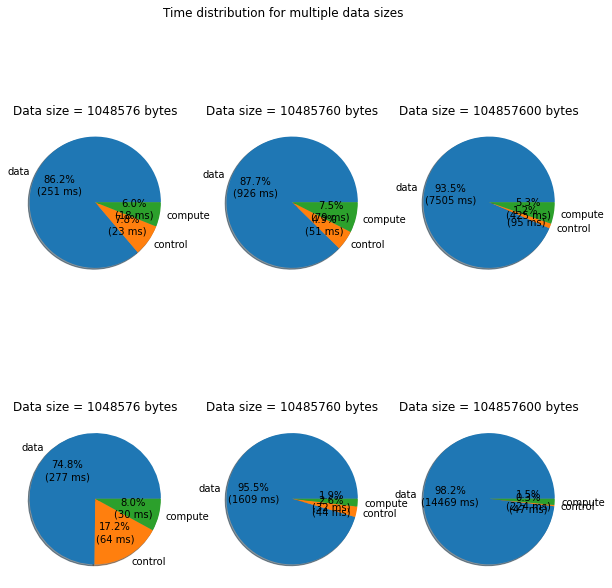

In [4]:
# Visualization 2 and 5. Piecharts and averages for each data size

# For each data size, read up a file which should contain the data I need based on the experiment runner.

# TODO need to do the all-up-OFF as well
# Need to do it for the other data sizes as well

#     Create subplots for each case: 3 data sizes, on/off
fig, axs = plt.subplots(2,3, figsize=(10,10))

fig.suptitle("Time distribution for multiple data sizes")
    
data_sizes = [1048576, 10485760, 104857600]
for i in range(3):
    d = data_sizes[i]
    input_file_on = "all-up-on-d{:d}.csv".format(d)
    input_file_off = "all-up-off-d{:d}.csv".format(d)
    data_on = read_and_parse(input_file_on)
    data_off = read_and_parse(input_file_off)
    
    piechart(data_on, d, axs[0,i])
    piechart(data_off, d, axs[1, i])


In [5]:
input_file_on = "all-up-on-d{:d}.csv".format(104857600)
data_on = read_and_parse(input_file_on)
input_file_on = "all-up-off-d{:d}.csv".format(104857600)
data_off = read_and_parse(input_file_off)
# Either deploy step 4 everywhere as well, or do a workflow only with 3 steps.
# Or re-use the same step 1 multiple times. 
# The edge1 to cloud1 movement is so bad...
# Maybe tweak the data chunk size?
# Make the step 3 filtering - reduce the size actually?
# What am I trying to prove? local - zone internal - cross-zone - they increase exponentially. 
# I need to show that my solution radically helps with latencies by favoring local runs.
# If I force the edge1-> cloud movement, I'm shooting myself in the foot.
# Because I have 4 choices, round robin will choose


# Maybe increase the iterations? And add the orchestrator service checker so I don't have to wait around

# data_off was optimal from the edge1-> cloud1 perspective, that's why the numbers are so close to one another
# data_off has some cloud1-> cloud1 and edge1 -> edge1 difference, but these are minor.
data_on

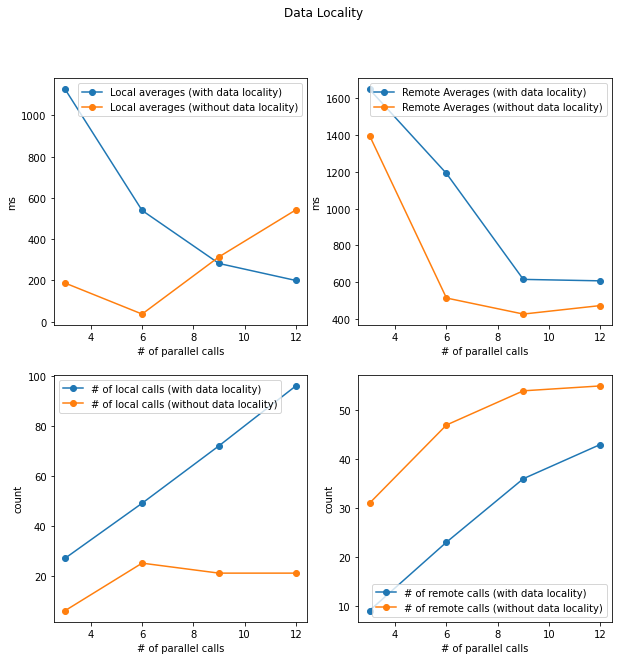

In [5]:
# For Visualization 6 and 7, I need 2 experiments in the same chart.

# x Axis = Request count
# y Axis = Count of Local calls, count of Remote calls.

# x Axis = Request count
# y Axis = Avg latency of local calls, avg latency of remote calls - this might require 2 different graphs due to scale issues


data_counts = [3, 6, 9, 12]
local_averages_on = []
remote_averages_on = []
local_count_on = []
remote_count_on = []

local_averages_off = []
remote_averages_off = []
local_count_off = []
remote_count_off = []

for c in data_counts:
    
    input_file_on = "data-loc-on-c{:d}.csv".format(c)
    input_file_off = "data-loc-off-c{:d}.csv".format(c)
    
    data_on = read_and_parse(input_file_on)
    data_off = read_and_parse(input_file_off)
    
    (local_count, remote_count, local_avg, remote_avg)= extract_local_remote_distr(data_on)
    
    local_count_on.append(local_count)
    remote_count_on.append(remote_count)
    local_averages_on.append(local_avg)
    remote_averages_on.append(remote_avg)
    
    
    (local_count, remote_count, local_avg, remote_avg)= extract_local_remote_distr(data_off)
    
    local_count_off.append(local_count)
    remote_count_off.append(remote_count)
    local_averages_off.append(local_avg)
    remote_averages_off.append(remote_avg)
    
draw_data_loc_plots(local_averages_on, remote_averages_on, local_count_on, remote_count_on,
                   local_averages_off, remote_averages_off, local_count_off, remote_count_off)

Text(0.5, 0.98, 'Network latency distribution')

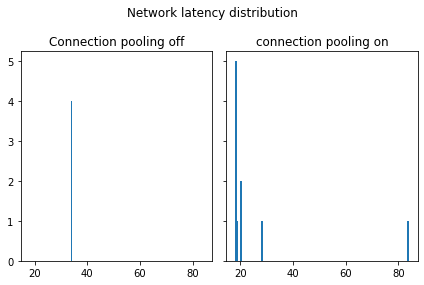

In [11]:
# For visualization 4, distribution of latencies on connection pooling. 

input_file_on = "cp-on-d1024.csv"
input_file_off = "cp-off-d1024.csv"

data_on = read_and_parse(input_file_on)
data_off = read_and_parse(input_file_off)

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, tight_layout=True)

axs[0].hist(data_off["triggerStepNetworkDuration"], bins=100)
axs[0].set_title("Connection pooling off")
axs[1].hist(data_on["triggerStepNetworkDuration"], bins=100)
axs[1].set_title("connection pooling on")

fig.suptitle("Network latency distribution")



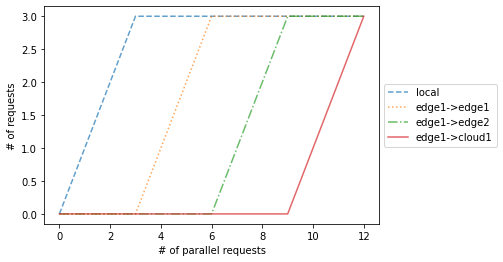

In [120]:
# For visualization 1, need to extract the # of calls from edge1 to -> edge1, edge2, Cloud, as the request count increases

parallel_requests = [0, 3, 6, 9, 12]
local_calls = [0]
edge1_calls = [0]
edge2_calls = [0]
cloud1_calls = [0]

def extract_zone_counts(data):
    localCalls = data.groupby("dataPullType")["tId"].count()["local"]
    edge1Calls= len(data[data["ToZone"] == "edge1"])
    edge2Calls= len(data[data["ToZone"] == "edge2"])
    cloud1Calls= len(data[data["ToZone"] == "cloud1"])
    
    return (localCalls, edge1Calls, edge2Calls, cloud1Calls)


for i in range(4):
    p = paraellel_requests[i + 1]
    input_file="continuum-on-c{:d}.csv".format(p)
    data = read_and_parse(input_file)
    
    (localCalls, edge1Calls, edge2Calls, cloud1Calls) = extract_zone_counts(data)
    local_calls.append(localCalls)
    edge1_calls.append(edge1Calls)
    edge2_calls.append(edge2Calls)
    cloud1_calls.append(cloud1Calls)


plt.plot(parallel_requests, local_calls, label='local', alpha=0.7, linestyle='dashed')
plt.plot(parallel_requests, edge1_calls, label='edge1->edge1', alpha=0.7, linestyle='dotted')
plt.plot(parallel_requests, edge2_calls, label='edge1->edge2', alpha=0.7, linestyle='dashdot')
plt.plot(parallel_requests, cloud1_calls, label='edge1->cloud1', alpha=0.7, linestyle='solid')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("# of parallel requests")
plt.ylabel("# of requests")
plt.show()
    
    
    

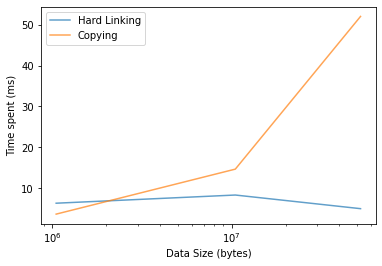

In [7]:
# For visualization 3,  Hard linking on-off I need 
data_sizes = [1048576, 10485760, 52428800]

on = []
off = []

for d in data_sizes:
    input_file_on = "hl-on-d{:d}.csv".format(d)
    input_file_off = "hl-off-d{:d}.csv".format(d)
    data_on = read_and_parse(input_file_on)
    data_off = read_and_parse(input_file_off)
    
    on.append(data_on["DataPullDuration"].mean())
    off.append(data_off["DataPullDuration"].mean())
    
plt.plot(data_sizes, on, label='Hard Linking', alpha=0.7)
plt.plot(data_sizes, off, label='Copying', alpha=0.7)
plt.legend()
plt.xscale('log')
plt.xlabel("Data Size (bytes)")
plt.ylabel("Time spent (ms)")
plt.show()
    

In [42]:
input_file_on = "cp-on-d1024.csv"
input_file_off = "cp-off-d1024.csv"

data_on = read_and_parse(input_file_on)
data_off = read_and_parse(input_file_off)

In [45]:
data_on["triggerStepNetworkDuration"].mean()

1.6

In [46]:
data_off["triggerStepNetworkDuration"].mean()

3.2